<a href="https://colab.research.google.com/github/whitejetyeh/RBMIsing/blob/master/MCMC_Ising_model(June_19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Spin distributions in the 2D Ising Model*
This code generates spin distributions in the 2D Ising model at given temperatures, i.e., data of stochastic binary values on a $N_s$ by $N_s$ grid. The process goes through Markov Chain Monte Carlo method, which randomly choose a spin to flip respect to  if the total energy will decrease and else if a random number $n_c \in [0,1]$ is larger than the probability difference between the flipped and un-flipped situations.

Ising model considers the Hamiltonian
$$E(\sigma)=-\sum\limits_{ij}J_{ij}\sigma^i\sigma^j - \mu \sum\limits_i h_j \sigma^j,$$
and the probability to observe a configuration $\sigma$ is given by the Boltzmann distribution
$$p(\sigma)=\frac{e^{-E(\sigma)}}{Z},\ \textrm{where } Z=\sum\limits_{\sigma}e^{-E(\sigma)}.$$
Here, I consider the simplist case of $J_{ij}=1$ if $i$ and $j$ are each other's nearest neighbor and $\mu=0$.

Mount google drive to save data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# MCMC Ising Model Construction

An easy to read and detailed MCMC Ising model explanation can be found on [mathworks.com](https://www.mathworks.com/matlabcentral/fileexchange/62194-ising-model-and-metropolis-algorithm).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time


def init_spins(n):
    """initialize a radom spin (1,-1) distribution on the nxn grid"""
    return np.random.choice([1,-1], size=(n,n))

def dE(spin,above,below,left,right):
    """the Ising model is defined as the following;
    H=-J*sum_(x,y=0..n-1)spin_(x,y)*spin_(x+/-1,y+/-1),
    i.e. Hamiltonian sums over J*spin multiplied by its neighbors with peroidic b.c.
    positive/negative J describes ferromagnetic/anti-ferromagnetic model
    we set J=1 W.L.O.G.; external field isn't considered for simplicity.
    dE=H(flipped spin)-H(spin)"""
    return 2*spin*(above+below+left+right)

def MonteCarlo(spins,temp):
    """Monte Carlo Markov Chain process randomly chooses a spin and throw a dice to find if the chosen spin will be flipped. The spin will be flipped if 1. dE<0 or 2. the dice is larger than the flipping difference in Boltzmann probability, exp(-dE/T). After enough steps, the spin distribution shall reflects the thermal distribution at temperature=T."""
    dim = len(spins)#spins must be in a squared grid.
#randomly choosing a spin
    x = np.random.randint(dim)
    y = np.random.randint(dim)
#chosen spin's nearest neighbors with the periodic boundary condition
    above = spins[(x-1)%dim][y]
    below = spins[(x+1)%dim][y]
    left = spins[x][(y-1)%dim]
    right = spins[x][(y+1)%dim]
#flipping condition
    delteE = dE(spins[x][y],above,below,left,right)
    if delteE <= 0 or np.random.random() < np.exp(-delteE/temp):
        spins[x][y] = -spins[x][y]
    return spins

def MCMC(temp,n,nsteps):
    """repeat MonteCarlo nsteps times for nxn grid at temp"""
    spins = init_spins(n)
    for step in range(nsteps):
        spins = MonteCarlo(spins,temp)
    return spins

def Emean(spins):
    """mean energy of spins, p.s. J=1 without external field"""
    EperSpin = -0.5*spins*(np.roll(spins,-1,axis=0)+\
                           np.roll(spins,1,axis=0)+\
                           np.roll(spins,-1,axis=1)+\
                           np.roll(spins,1,axis=1))
    return np.mean(EperSpin)

def EvsT(n=10,nsteps=10000,ntemps=100):
    '''output E vs T to check the code is functioning as expected'''
    kTc = 2/np.log(1+np.sqrt(2)) #Curie temperature (critical temp)
    kT = np.linspace(10**-5,2*kTc,num=ntemps)
    E = [] #mean energy per spin at temp
    
    start = time.time()
    for temp in kT:
        spins=MCMC(temp,n,nsteps)
        E.append(Emean(spins))
    
    #running mean for a window=1/10 of ntemps; take out 5 temp pts on both side
    smoothE=np.convolve(E,np.ones((11,))/11,mode='valid')
    smoothT=kT[5:-5]/kTc
    
    fig = plt.figure()
    plt.plot(kT/kTc,E,'ob',label='<E> data')
    plt.plot(smoothT,smoothE,'-r',label='running mean')
    plt.title('mean energy per spin vs temperature')
    plt.xlabel('T/Tc')
    plt.ylabel('<E> per spin')
    plt.legend(loc='best')
    fig.savefig('EvsTforTesting.png')
    end = time.time()
    print('execution time = ',end-start)

# Generate the spin distributions at given temperatures


In [0]:
dim = 12#10 # spins per dimension
nsteps = 40000#10000 # number of iterations in the Monte Carlo simulation
ndata = 2000 # number of data for spin distributions at the same temperature 
#temperatures=[0.27, 1.27, 2.27, 3.27, 4.27]
temperatures=[0.27, 2.27, 4.27]

for temp in temperatures:
    file='/content/gdrive/My Drive/IsingModel/t='+str(temp)+'.csv'
    start = time.time()
    with open(file,'ab+') as f:    
        for j in range(ndata):
            spins = MCMC(temp,dim,nsteps)
            np.savetxt(f,spins,fmt='%i',delimiter=',')
    end = time.time()
    print('execution time = ',end-start)

Data represents spin distributions at fixed temperatures. Its dimensions (dim*ndata,dim) refer to data of spins on a dim by dim grid stacked up ndata times. The whole process of 5 different temperatures takes longer than 10 minutes.
$$\begin{align*}
\textrm{cost time (minutes)}&&\textrm{dim}&&\textrm{iterations}&&\textrm{ndata}\\
12 && 10 && 1e+4 && 2000\\
25 && 20 && 2e+4 && 2000\\
51 && 20 && 4e+4 && 2000\\
\end{align*}$$


# Mean energy versus temperature
To check this MCMC Ising model, I plot the mean spin energy versus temperature. The theoretical expectation is that the curve looks like a $tanh(T)$ function. The curve is almost flat at -2 and 2 for $T<T_C$ and $T>T_C$ respectively. Near $T_C$, there is a phase transition sharply increasing from -2 to 0.

The phase trainsition is clear at $T=T_C$, and the running mean of data does look like the expected $tanh$, but data points spread far from the running mean because of the stochastic nature on a finite grid. Its possible to observe the system with excessive energy such that the spin distributions are identical even from two different temperatures. When building a neuro network to classify temperature from a given spin distribution, one shall keep in mind that the overlapped distributions from two temperature labels sets an upper bound on the achivable accuracy.


execution time =  7.986135482788086


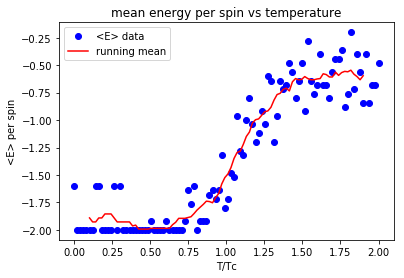

In [0]:
EvsT(10,10000,100)

On the 10 by 10 grid, data points randomly spread far from the running mean. Several data points have higher energy even at a lower temperature.

execution time =  30.736976146697998


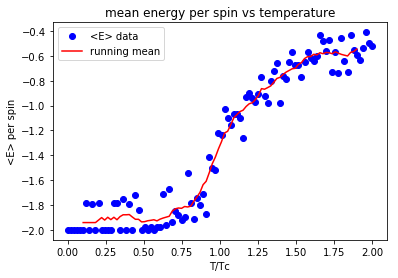

In [0]:
EvsT(20,40000,100)

We can see the data points shrinking towards the running mean with a finer  20 by 20 grid.